**Problem Statement:**
The problem being addressed is the early detection of brain tumors using machine learning and neural networks enabling enable healthcare professionals to detect brain tumors earlier, leading to improved treatment planning and better patient outcomes.

**Why is this problem important?**
Early detection of brain tumors is crucial for timely medical intervention, improving patient outcomes, and reducing healthcare costs. Machine learning and neural networks offer a non-invasive approach to accurately identify brain tumors from medical images, enabling quicker diagnosis without the need for invasive procedures like biopsies. This technology could lead to better treatment planning, enhanced patient care, and ultimately, improved survival rates for individuals with brain tumors.

**What is your idea to solve the problem?**
The primary idea is to develop a computer-aided diagnosis (CAD) system capable of automatically detecting the presence of brain tumors in medical images, such as MRI scans. The system can differentiate between tumor and non-tumor regions with high accuracy and also highlights the specific image regions critical for its diagnosis.

**What differences you could make with your data science approach?**
Efforts in data science for brain tumor detection enhance report comprehensibility for patients through clear, concise summaries and intuitive visualizations. This approach aims to empower patients with accessible information about their health conditions, facilitating informed discussions and decisions regarding treatment options. By improving report readability and providing visual aids, patients can better understand their diagnosis and engage more actively in their healthcare journey, ultimately leading to improved patient satisfaction and outcomes.

Mounting drive to access the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required libraries

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:

import numpy as np

import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

**Data collection and Exploratory data analysis**

In [5]:
# Define the paths to the training and testing directories
train_dir = '/content/drive/MyDrive/DM project/brain tumor/Training'
test_dir = '/content/drive/MyDrive/DM project/brain tumor/Testing'

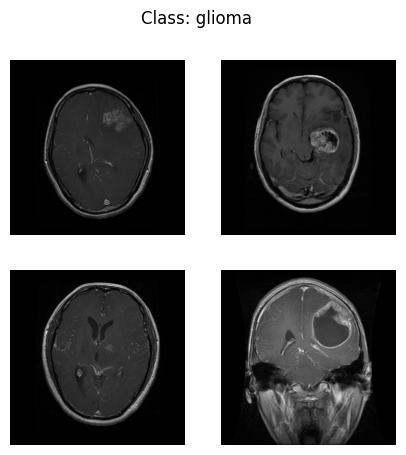

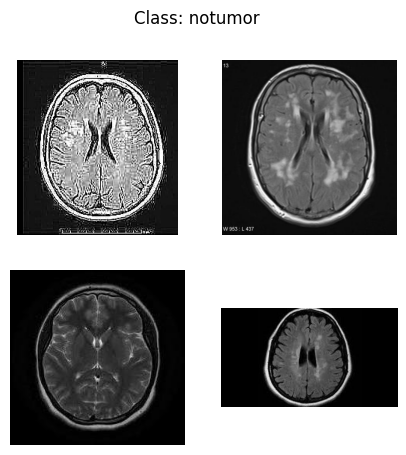

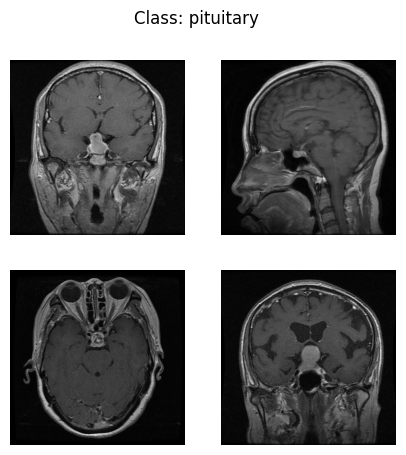

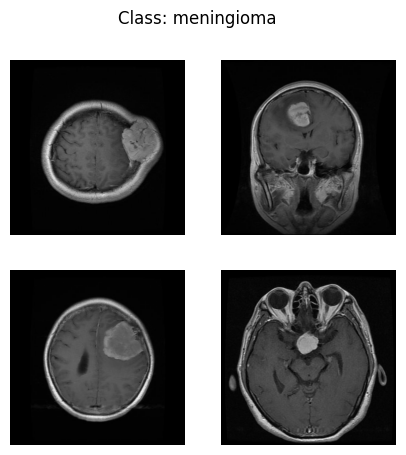

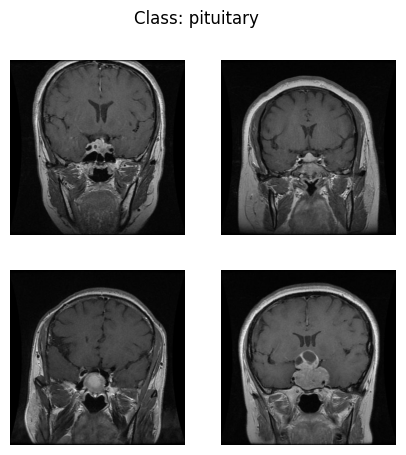

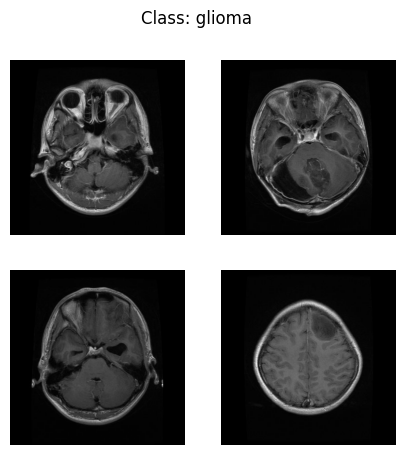

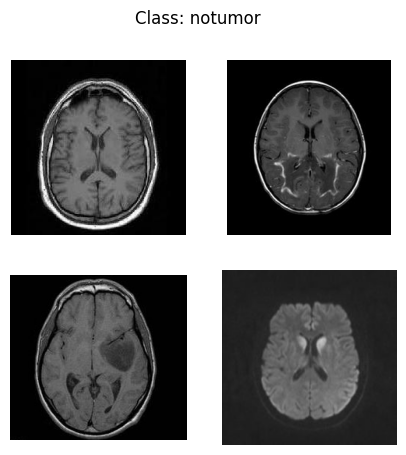

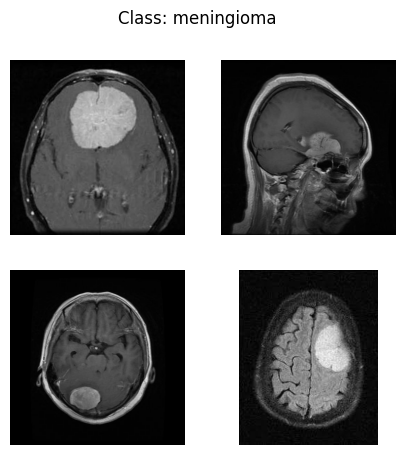

In [5]:
import os
import cv2
from matplotlib import pyplot as plt

# Function to load images from a directory and visualize them
def visualize_images(directory, examples_per_class=4, grid_size=(2, 2)):
    for class_folder in os.listdir(directory):
        path = os.path.join(directory, class_folder)
        images = os.listdir(path)[:examples_per_class]
        fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
        fig.suptitle(f'Class: {class_folder}')
        axs = axs.flatten()  # Flatten the grid to iterate easily
        for i, img in enumerate(images):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            axs[i].imshow(image)
            axs[i].axis('off')
        plt.show()

# Visualize training images
visualize_images(train_dir)

# Visualize testing images
visualize_images(test_dir)

Feature extraction

In [6]:
import cv2
import numpy as np
import os
import skimage.feature as feature
from skimage.feature import greycomatrix,greycoprops
from skimage.filters import gabor

#Pre-processing images and feature extraction
def feature_extraction(directory):
    ft = []
    l = []

    #Iterating class folders
    for folder in os.listdir(directory):
        cl_path = os.path.join(directory, folder)
        #Iterating images in class folders
        for filename in os.listdir(cl_path):
            path = os.path.join(cl_path, filename)
            #Calling function to Pre-process and extract features of individual image
            features = image_preprocessing(path)
            #Adding to the lists
            ft.append(features)
            l.append(folder)

    return ft, l

#Pre-processing and feature extraction of individual image
def image_preprocessing(path):
    #Grayscaling
    grayImage = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was read correctly
    if grayImage is None:
        raise ValueError(f"Image not found at path: {path}")

    # Preprocessing: Resize and Gaussian blur
    resizedImage = cv2.resize(grayImage, (224, 224))
    blurredImage = cv2.GaussianBlur(resizedImage, (5, 5), 0)

    # Feature Extraction
    # Gabor Features
    gabor_ft = []
    for th in range(4):
        th = th / 4. * np.pi
        for sg in (1, 3):
            for fq in (0.05, 0.25):
                filt_real, filt_imag = gabor(blurredImage, fq, theta=th, sigma_x=sg, sigma_y=sg)
                gabor_ft.append(filt_real.mean())
                gabor_ft.append(filt_imag.mean())

    # GLCM Features
    glcm_ft = greycomatrix(resizedImage, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    ft_contrast = greycoprops(glcm_ft, 'contrast').flatten()
    ft_dissimilarity = greycoprops(glcm_ft, 'dissimilarity').flatten()
    ft_homogeneity = greycoprops(glcm_ft, 'homogeneity').flatten()
    ft_energy = greycoprops(glcm_ft, 'energy').flatten()
    ft_correlation = greycoprops(glcm_ft, 'correlation').flatten()
    ft_asm = greycoprops(glcm_ft, 'ASM').flatten()

    # Combine all features into a single list
    combined_ft = list(gabor_ft) + list(ft_contrast) + list(ft_dissimilarity) + list(ft_homogeneity) + list(ft_energy) + list(ft_correlation) + list(ft_asm)

    return combined_ft

# Preprocess and extract features from training and testing sets
training_ft, training_labels = feature_extraction(train_dir)
testing_ft, testing_labels = feature_extraction(test_dir)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1

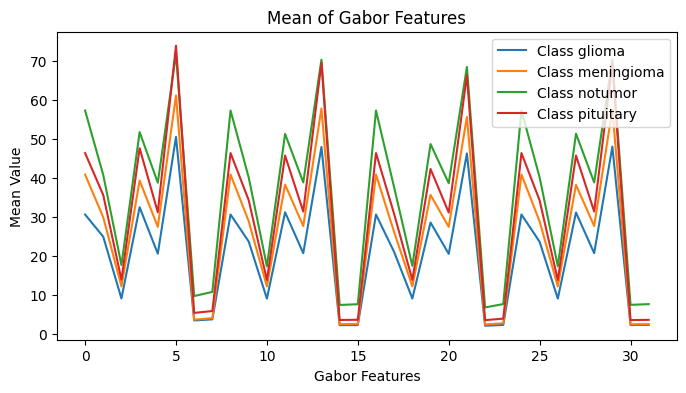

In [7]:
import matplotlib.pyplot as plt

#Converting to a numpy array
ft_array = np.array(training_ft)
l_array = np.array(training_labels)

#Plotting the mean of the Gabor features for each class
gabor_ft = ft_array[:, 0:32]
classes = np.unique(l_array)

plt.figure(figsize=(8, 4))
for cls in classes:
    #Calculating the mean of Gabor features
    class_gabor_means = gabor_ft[l_array == cls].mean(axis=0)
    plt.plot(class_gabor_means, label=f'Class {cls}')

plt.title('Mean of Gabor Features')
plt.xlabel('Gabor Features')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

Model Building and Evaluation: Support Vector Machine

In [8]:
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

#Splitting the training data
X_train, X_val, y_train, y_val = train_test_split(training_ft, training_labels, test_size=0.2, random_state=42)

#Initializing the SVM model
svm_model = svm.SVC(kernel='linear', C=1.0, probability=True)

#Training the SVM model
svm_model.fit(X_train, y_train)

#Validating the model
svm_val_pred = svm_model.predict(X_val)
svm_val_acc = accuracy_score(y_val, svm_val_pred)
print(f"Validation Accuracy: {svm_val_acc:.2f}")
print("Report of Validation Classification:\n", classification_report(y_val, svm_val_pred))

#Testing the model on the testing set using the true labels
svm_test_pred = svm_model.predict(testing_ft)
svm_test_acc = accuracy_score(testing_labels, svm_test_pred)
print(f"Test Accuracy: {svm_test_acc:.2f}")
print("Test Classification Report:\n", classification_report(testing_labels, svm_test_pred))

print("Test Predictions:", svm_test_pred)

Validation Accuracy: 0.82
Report of Validation Classification:
               precision    recall  f1-score   support

      glioma       0.81      0.78      0.80       288
  meningioma       0.75      0.74      0.75       273
     notumor       0.90      0.89      0.90       309
   pituitary       0.80      0.84      0.82       273

    accuracy                           0.82      1143
   macro avg       0.81      0.81      0.81      1143
weighted avg       0.82      0.82      0.82      1143

Test Accuracy: 0.76
Test Classification Report:
               precision    recall  f1-score   support

      glioma       0.79      0.72      0.75       300
  meningioma       0.62      0.58      0.60       306
     notumor       0.80      0.88      0.84       405
   pituitary       0.80      0.82      0.81       320

    accuracy                           0.76      1331
   macro avg       0.75      0.75      0.75      1331
weighted avg       0.76      0.76      0.76      1331

Test Predictions:

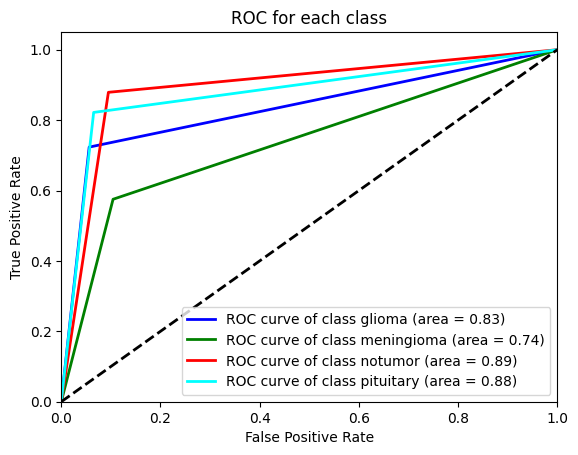

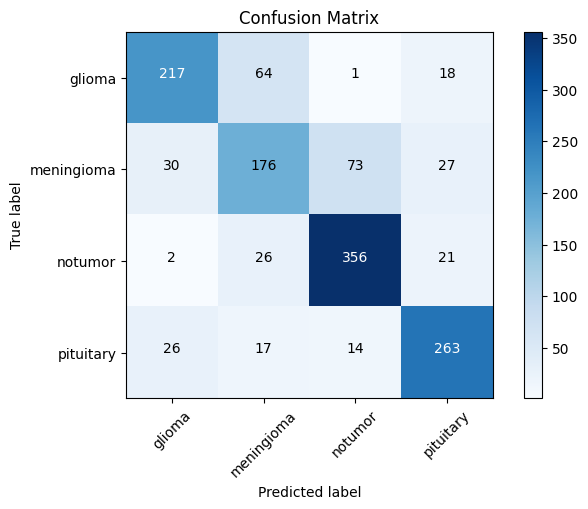

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

#Binarizing the labels
cls = np.unique(testing_labels)
y_test_bin_svm = label_binarize(testing_labels, classes=cls)
y_pred_bin_svm = label_binarize(svm_test_pred, classes=cls)

#Computing ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(cls)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_svm[:, i], y_pred_bin_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plotting all ROC curves
plt.figure()
clrs = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
for i, clr in zip(range(len(cls)), clrs):
    plt.plot(fpr[i], tpr[i], color=clr, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cls[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for each class')
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix
cm = confusion_matrix(testing_labels, svm_test_pred)
plt.figure(figsize=(7, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(cls))
plt.xticks(tick_marks, cls, rotation=45)
plt.yticks(tick_marks, cls)

threshold = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model Building and Evalution: Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#Splitting the training data
X_train, X_val, y_train, y_val = train_test_split(training_ft, training_labels, test_size=0.2, random_state=42)

#Initializing the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#Training the Random Forest model
rf_model.fit(X_train, y_train)

#Validating the model
rforest_val_pred = rf_model.predict(X_val)
rforest_val_acc = accuracy_score(y_val, rforest_val_pred)
print(f"Validation Accuracy: {rforest_val_acc:.2f}")
print("Validation Classification Report:\n", classification_report(y_val, rforest_val_pred))

#Testing the model on the testing set
rforest_test_pred = rf_model.predict(testing_ft)
rforest_test_acc = accuracy_score(testing_labels, rforest_test_pred)
print(f"Test Accuracy: {rforest_test_acc:.2f}")
print("Test Classification Report:\n", classification_report(testing_labels, rforest_test_pred))

print("Test Predictions:", rforest_test_pred)

Validation Accuracy: 0.89
Validation Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.83      0.86       288
  meningioma       0.82      0.79      0.81       273
     notumor       0.93      0.97      0.95       309
   pituitary       0.90      0.97      0.93       273

    accuracy                           0.89      1143
   macro avg       0.89      0.89      0.89      1143
weighted avg       0.89      0.89      0.89      1143

Test Accuracy: 0.89
Test Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.76      0.82       300
  meningioma       0.79      0.83      0.81       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.92      0.94      0.93       320

    accuracy                           0.89      1331
   macro avg       0.89      0.88      0.89      1331
weighted avg       0.89      0.89      0.89      1331

Test Predictions: ['

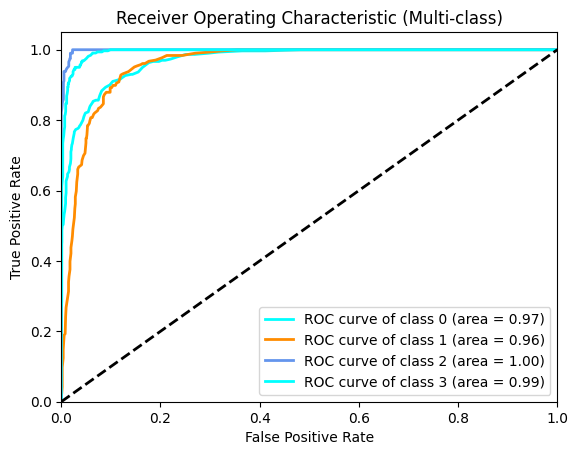

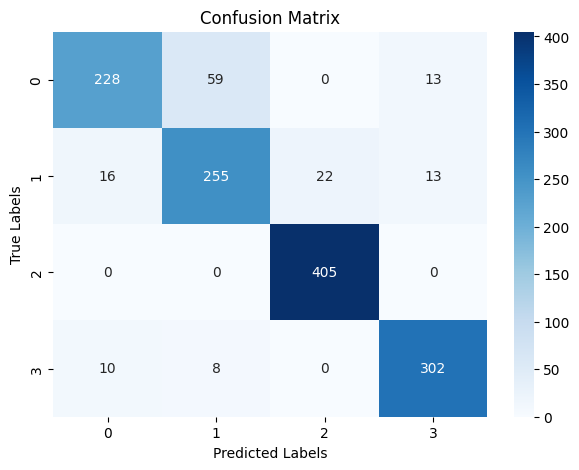

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Binarizing the labels
y_test_binarized_rf = label_binarize(testing_labels, classes=np.unique(testing_labels))

#Computing ROC curve and ROC area
fpr = dict()
tpr = dict()
roc_auc = dict()
n_cls = y_test_binarized_rf.shape[1]

# Predict probabilities for each class
probabilities = rf_model.predict_proba(testing_ft)

# Compute ROC curve and ROC area for each class
for i in range(n_cls):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized_rf[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

# Plot ROC curve for each class
clrs = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, clr in zip(range(n_cls), clrs):
    plt.plot(fpr[i], tpr[i], color=clr, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(testing_labels, rforest_test_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Prediction using Deep Learning

Dataset generation

In [8]:
#importing necessary libraries
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#creating training dataset
train_dataset = image_dataset_from_directory(
    directory="/content/drive/MyDrive/DM project/brain tumor/Training",
    labels="inferred",  #infer labels from directory structure
    label_mode="categorical",  #use categorical labels
    color_mode="rgb",  #color mode for images (RGB)
    batch_size=32,
    image_size=(224, 224),  #resizing images to (224, 224)
    shuffle=True,  #shuffle the dataset during training
    validation_split=0.2,
    subset="training",  #using this subset for training data
    seed=30  #random seed for reproducibility
)

# Creating validation dataset
val_dataset = image_dataset_from_directory(
    directory="/content/drive/MyDrive/DM project/brain tumor/Training",  # Same path as training dataset
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset="validation",  # Use this subset for validation data
    seed=30
)

# Creating test dataset
test_dataset = image_dataset_from_directory(
    directory="/content/drive/MyDrive/DM project/brain tumor/Testing",  # Path to the test dataset
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=(224, 224),
    shuffle=False  # Do not shuffle test data
)

#defining callback functions for training
callback_list = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=3)
]

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1331 files belonging to 4 classes.


In [9]:
print(f"Total classes:= {train_dataset.class_names}")

Total classes:= ['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
import tensorflow as tf
#set autotune to use dynamic runtime parameter tuning
AUTOTUNE = tf.data.AUTOTUNE
#cache the training dataset in memory for faster data retrieval during training
train_dataset = train_dataset.cache()
#prefetch training dataset batches asynchronously to optimize data loading
#use AUTOTUNE to determine an optimal buffer size based on system resources
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#cache the validation dataset in memory for faster data retrieval during validation
val_dataset = val_dataset.cache()
#prefetch validation dataset batches asynchronously to optimize data loading
#use AUTOTUNE to determine an optimal buffer size based on system resources
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

Model building and Evaluation: Convolutional Neural Network

In [11]:
#define Base_Model (EfficientNetB0)
base_model = tf.keras.applications.EfficientNetB0(include_top = False) #excluding the top layer
base_model.trainable = False     #freezing the model parameters
inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer") #define the input layer
layer = base_model(inputs)
layer = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(layer) #add a Conv2D layer which we will use in the segmentation as the Top conv Layer
layer = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(layer) #add Global Average Pooling Layer 2D
outputs = tf.keras.layers.Dense(4 , #since, there are 4 classes
                                activation = "softmax" ,
                                name = "Output_layer")(layer)
model = tf.keras.Model(inputs , outputs)

#compiling the model
model.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#multiclass classification
    optimizer = tf.keras.optimizers.Adam() , #adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy']
)


16705208/16705208 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Top_Conv_Layer (Conv2D)     (None, 7, 7, 32)          368672    
                                                                 
 Global_avg_Pooling_2D (Glo  (None, 32)                0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 4418375 (16.85 MB)
Trainable params: 368804 (1.

In [13]:
#training the model for 5 epochs
history = model.fit(train_dataset
                              , validation_data = val_dataset ,
                              epochs = 5  ,
                              verbose = 1 ,
                              callbacks = callback_list)

Epoch 1/5
143/143 [==============================] - 59s 200ms/step - loss: 0.4295 - accuracy: 0.8379 - val_loss: 0.2945 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 2/5
143/143 [==============================] - 11s 77ms/step - loss: 0.2319 - accuracy: 0.9116 - val_loss: 0.2234 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 3/5
143/143 [==============================] - 12s 81ms/step - loss: 0.1585 - accuracy: 0.9396 - val_loss: 0.2184 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 4/5
143/143 [==============================] - 11s 76ms/step - loss: 0.1340 - accuracy: 0.9497 - val_loss: 0.1929 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 5/5
143/143 [==============================] - 11s 77ms/step - loss: 0.1086 - accuracy: 0.9602 - val_loss: 0.1846 - val_accuracy: 0.9273 - lr: 0.0010


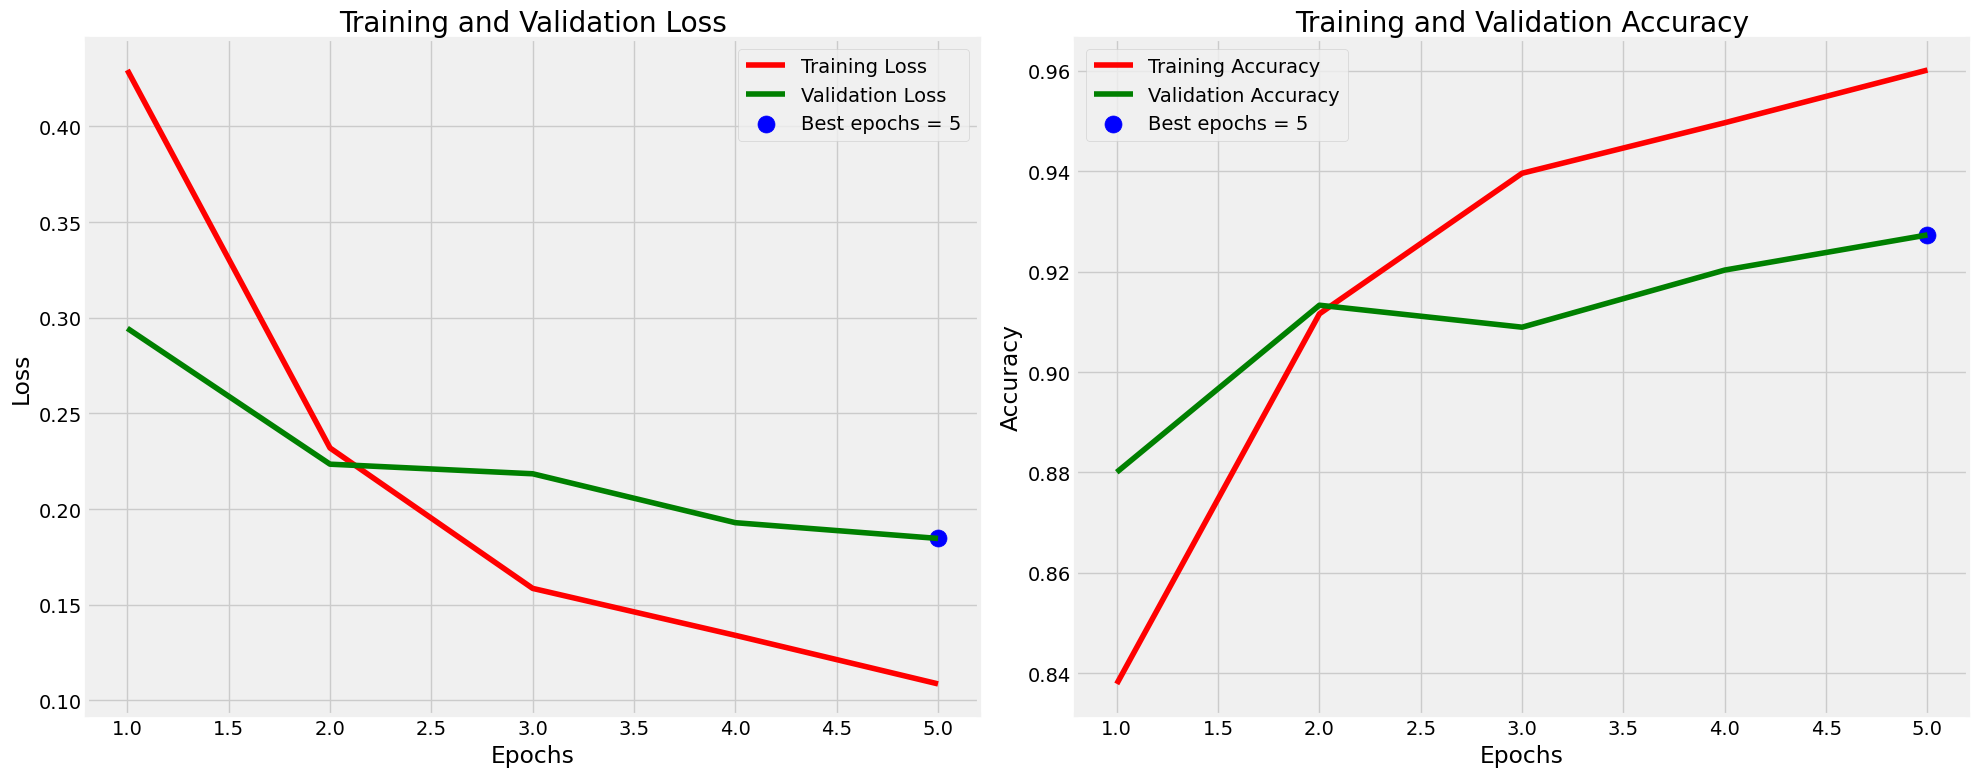

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(1, len(train_loss) + 1)

    #finding index of epoch with the lowest validation loss
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    #finding index of epoch with the highest validation accuracy
    index_acc = np.argmax(val_accuracy)
    val_highest = val_accuracy[index_acc]

    loss_label = f'Best epochs = {str(index_loss + 1)}'
    acc_label = f'Best epochs = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    #plot training and validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    #plot training and validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_curves(history)

In [16]:
#evaluate the model on the training dataset
train_score = model.evaluate(train_dataset , verbose = 1)
#evaluate the model on the validation dataset
valid_score = model.evaluate(val_dataset , verbose = 1)
#evaluate the model on the test dataset
test_score = model.evaluate(test_dataset  , verbose = 1)

#print the evaluation results for the training dataset
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
#print the evaluation results for the validation dataset
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
#print the evaluation results for the test dataset
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

42/42 [==============================] - 56s 1s/step - loss: 0.1869 - accuracy: 0.9264
Train Loss:  0.08286649733781815
Train Accuracy:  0.9663019776344299
--------------------
Validation Loss:  0.18461200594902039
Validation Accuracy:  0.9273204803466797
--------------------
Test Loss:  0.18686401844024658
Test Accuracy:  0.926371157169342


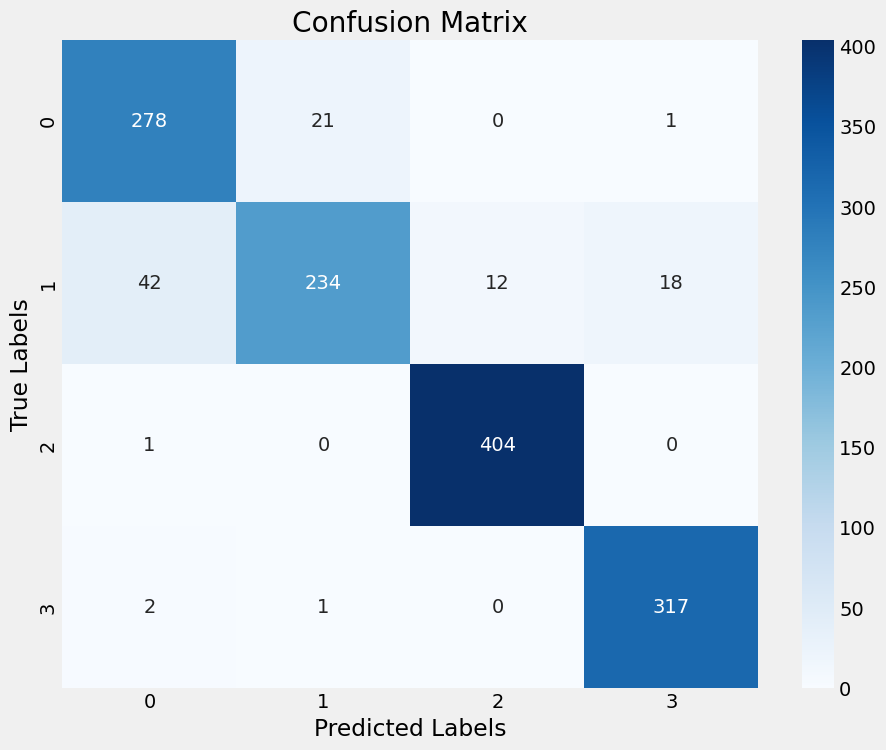

F1 Score (Micro Average): 0.9264


In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

#initialize empty lists to store true labels and predictions
y_true = []
y_pred = []

#iterate through the test dataset to gather true labels and model predictions
for images, labels in test_dataset:
    #predict labels using the model
    predictions = model(images)  # Assuming 'model' is your defined model
    #get predicted class indices
    batch_pred = np.argmax(predictions, axis=1)
    #append true labels and predictions to the lists
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels to indices
    y_pred.extend(batch_pred)

#convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

#compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

#plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#calculate F1 score
f1_micro = f1_score(y_true, y_pred, average='micro')
print(f"F1 Score (Micro Average): {f1_micro:.4f}")


Brain Tumor Prediction

In [18]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
import cv2  #cv2 for heatmap visualization
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

#define the last convolutional layer name
last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def generate_gradcam_heatmap(img_array, model = model , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    #first creating a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    #computing the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    #gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    #vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    #selecting the activations of the last convolutional layer for the first image in the batch
    last_conv_layer_output = last_conv_layer_output[0]

    #computing the weighted sum of the activations in the last convolutional layer with the importance of each channel (pooled gradients)
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]

    #squeeze the heatmap tensor to remove any single-dimensional entries
    heatmap = tf.squeeze(heatmap)

     #normalizing the heatmap to be between 0 and 1 for visualization purposes
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    #load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    #rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    #colormap to colorize heatmap
    jet = mpl.colormaps["jet"]
    #RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    #create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    #superimposing the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    #display Grad CAM
    if view :
        display(Image(cam_path))

#map model output probabilities to human-readable class labels
def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction

#function to make predictions on a given image path using the specified model and generate a Grad-CAM visualization
def make_prediction (img_path , model = model , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = model.predict(img_array)
    heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

Enter the path to the brain image: /content/drive/MyDrive/DM project/brain tumor/Testing/glioma/Te-gl_0013.jpg
1/1 [==============================] - 3s 3s/step


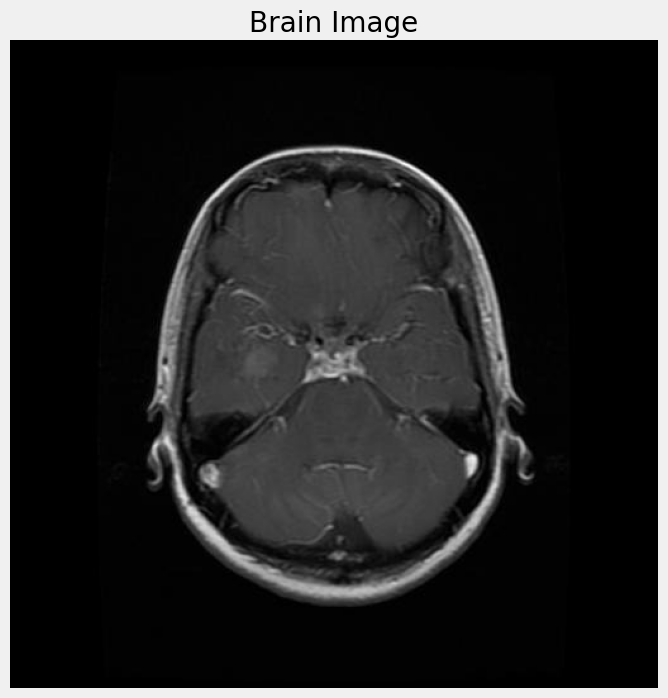

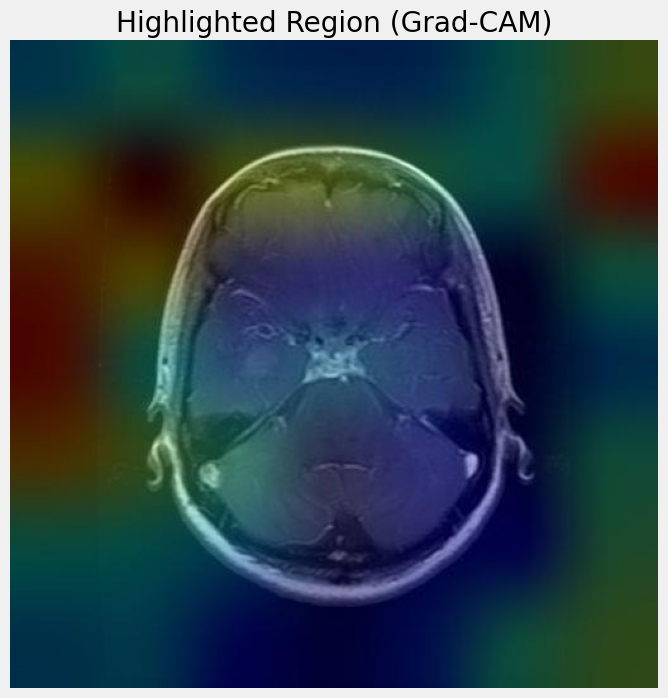

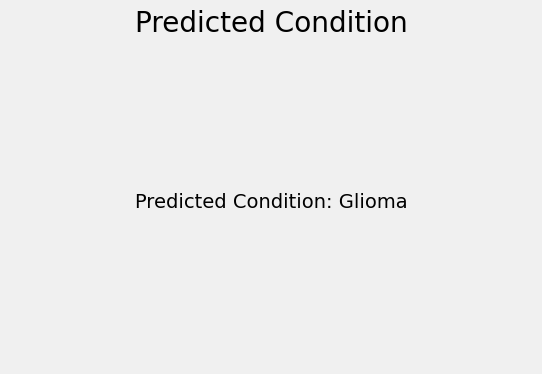

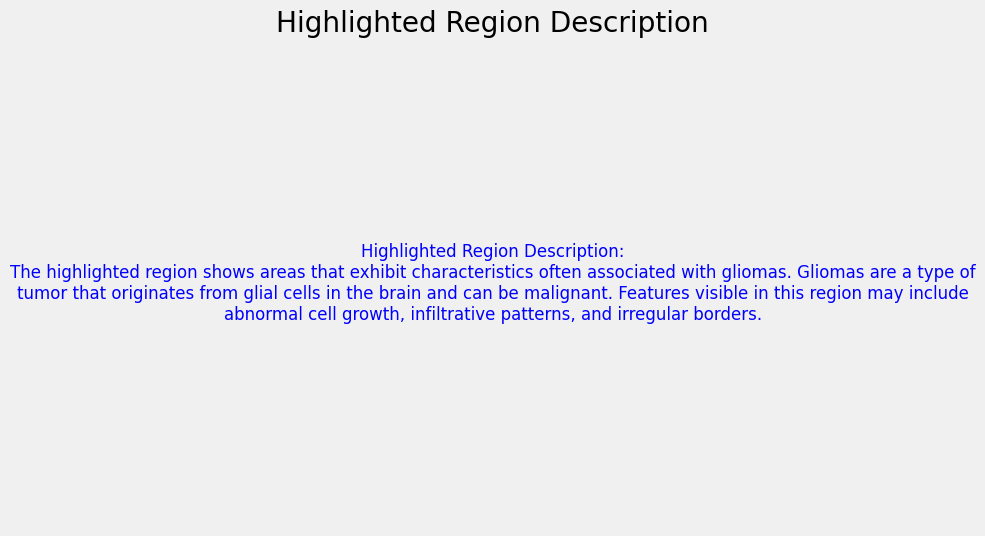

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

def generate_report(img_path, model=model, last_conv_layer_name=last_conv_layer_name, cam_path="cam.jpg", view=False):
    #generate Grad-CAM visualization and obtain predictions
    img_array = get_img_array(img_path, size=(224, 224))
    heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam(img_path, heatmap, cam_path=cam_path, view=view)
    preds = model.predict(img_array)
    prediction = decode_predictions(preds)

    report_content = {
        "image_path": img_path,
        "cam_path": cam_path,
        "prediction": prediction,
        "heatmap": heatmap
    }
    display_report(report_content)

def display_report(report_content):
    #load and display the original image
    original_img = Image.open(report_content["image_path"])
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title("Brain Image")

    #display the Grad-CAM visualization
    cam_img = Image.open(report_content["cam_path"])
    plt.figure(figsize=(8, 8))
    plt.imshow(cam_img)
    plt.axis('off')
    plt.title("Highlighted Region (Grad-CAM)")

    #display the prediction
    prediction = report_content["prediction"]
    plt.figure(figsize=(6, 4))
    plt.text(0.5, 0.5, f"Predicted Condition: {prediction}", ha='center', va='center', fontsize=14)
    plt.axis('off')
    plt.title("Predicted Condition")

    #describe the highlighted region based on the predicted condition
    describe_highlighted_region(report_content)

    #show the description at the end of the report
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, f"Highlighted Region Description:\n{report_content['description']}",
             ha='center', va='center', fontsize=12, wrap=True, color='blue')
    plt.axis('off')
    plt.title("Highlighted Region Description")

    plt.show()

def make_prediction_and_generate_report(model=model, last_conv_layer_name=last_conv_layer_name):
    #prompt user to enter the path to the image
    img_path = input("Enter the path to the brain image: ")

    #generate report for the user input image
    generate_report(img_path, model, last_conv_layer_name)

def describe_highlighted_region(report_content):
    #retrieve the heatmap and predicted class
    heatmap = report_content["heatmap"]
    predicted_class = report_content["prediction"]

    #describe the highlighted region based on the heatmap and predicted class
    if predicted_class == "Glioma":
        region_description = (
            "The highlighted region shows areas that exhibit characteristics often associated with gliomas. "
            "Gliomas are a type of tumor that originates from glial cells in the brain and can be malignant. "
            "Features visible in this region may include abnormal cell growth, infiltrative patterns, and irregular borders."
        )
    elif predicted_class == "Meningioma":
        region_description = (
            "The highlighted region suggests features consistent with meningiomas, which are generally benign tumors "
            "arising from the meninges (protective membranes around the brain). "
            "Meningiomas typically have well-defined borders and can sometimes exhibit calcifications."
        )
    elif predicted_class == "No Tumor":
        region_description = (
            "The highlighted region shows normal brain tissue without any apparent tumor or abnormality. "
            "This indicates that no pathological features related to tumors are present in this area."
        )
    elif predicted_class == "Pituitary":
        region_description = (
            "The highlighted region may indicate features related to the pituitary gland. "
            "Pituitary tumors can affect hormone production and regulation, potentially leading to various symptoms depending on the specific tumor type."
        )
    else:
        region_description = (
            "The highlighted region shows features that are characteristic of the predicted condition. "
            "Further detailed analysis by a medical professional is recommended for accurate interpretation and diagnosis."
        )

    #store the description in the report content
    report_content["description"] = region_description

make_prediction_and_generate_report()


**Results and analysis:**

**SVM**
The performance of SVM was evaluated using accuracy, precision, recall, F1-score, and other relevant metrics. The overall accuracy of the model is 76% and it is fairly effective in detecting pituitary, glioma and no tumor with the precision at 82%. While it is less precise while detecting meningioma tumors with precision at 61%.
Confusion matrices generated for SVM show high accuracy in detecting ‘notumor’ cases but it is showing confusion while differentiating between ‘glioma’ and ‘meningioma’ cases. ROC curves were used to check the effectiveness of the model in detecting the classes of brain tumors. The area under each class are - glioma (0.83), meningioma (0.72), notumor (0.89) and pituitary (0.88), which indicate that there are still improvements required in the model for accurate detection of tumor categories.




**Random Forest**


After evaluating the performance of the random forest model, we can observe that the overall accuracy of the model is 89% for detecting brain tumors. It shows high accuracy while detecting ‘notumor’ cases with the precision of 94%. It also shows high accuracy in detecting ‘pituitary’ tumors with the precision of 92%. But the model can still be improved for ‘glioma’ and ‘meningioma’ classes with precision of 89% and 80% respectively. The confusion matrix for random forest also exhibits confusion between ‘glioma’ and ‘meningioma’ tumors as support vector machine. The ROC curve for random forest has also exhibited impressive results while distinguishing between different classes of tumor. The results of the random forest model shows that this is an accurate model for detecting the tumor and its types.

**CNN**

The performance of the Convolutional Neural Network was evaluated using accuracy and loss. Comparison between training and validation losses, and comparison between training and validation accuracies were conducted to gain further insights into the neural network's performance and behavior. The model showed a steady increase in training accuracy with each epoch, reaching a high of 0.95 by the final epoch. Training loss decreased significantly from 0.7136 in the first epoch to 0.1179 in the fifth epoch indicating effective learning and convergence of the model. Validation accuracy remained consistently high throughout training, peaking at 92.12% in the fourth epoch. Validation loss shows a decreasing trend over epochs reflecting the model’s ability to generalize well to unseen data. The confusion matrix for CNN also exhibits a high confusion between ‘glioma’ and ‘meningioma’ tumors. In addition to assessing the Convolutional Neural Network (CNN), Grad-CAM was utilized to highlight the important regions of the image helping in the detection process.
In addition to assessing the Convolutional Neural Network (CNN), Grad-CAM was utilized to highlight  the important regions of the image helping in the detection process.